# Guided Project: Predicting Car Prices

## Introduction

The goal is to predict the prices of a car using the fundamental machine learning technique of k-nearest neighbors algorithm. The file used is `imports-85.data`, an Automobile Data Set from 1985 Ward's Automotive Yearbook which is extracted by Jeffrey C. Schlimmer from UCI. The data set is downloadable [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data), and has some [description here](https://archive.ics.uci.edu/ml/datasets/automobile).

## 1. Importing Data Set

We import the data set `imports-85.data` then determine the numerical columns that can be used as features and the target column for our ML implementation.

Apparently the raw data set does not have the column attributes as described in the [data set's documentation](https://archive.ics.uci.edu/ml/datasets/automobile). We need to manually enter the column names and pass it as a parameter when reading the file.

In [1]:
import numpy as np
import pandas as pd

column_names = ["symboling", "normalized_losses", "make", "fuel_type",
                "aspiration", "num_of_doors", "body_style", "drive_wheels",
                "engine_location", "wheel_base", "length", "width",
                "height", "curb_weight", "engine_type", "num_of_cylinders",
                "engine_size", "fuel_system", "bore", "stroke",
                "compression_ratio", "horsepower", "peak_rpm", "city_mpg",
                "highway_mpg", "price"]
cars = pd.read_csv("imports-85.data", names = column_names)
print(cars.info())
print(cars.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized_losses    205 non-null object
make                 205 non-null object
fuel_type            205 non-null object
aspiration           205 non-null object
num_of_doors         205 non-null object
body_style           205 non-null object
drive_wheels         205 non-null object
engine_location      205 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_type          205 non-null object
num_of_cylinders     205 non-null object
engine_size          205 non-null int64
fuel_system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression_ratio    205 non-null float64
horsepower           205 non-nul

From the first several rows, there are 18 numeric columns:

`"symboling", "normalized_losses", "num_of_doors", "wheel_base", "length", "width",
"height", "curb_weight", "num_of_cylinders",
"engine_size", "bore", "stroke",
"compression_ratio", "horsepower", "peak_rpm",
"city_mpg", "highway_mpg", "price"`

The target column for our ML implementation is clearly `price`. When implementing k-nearest neighbors method, it is better to consider continuous ranges instead of discrete ranges. Therefore, `symboling`, `num_of_doors` and `num_of_cylinders` are not included (see [the data set description, part 7](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names) for more information regarding continuous and discrete values). The remaining 14 numeric columns can be used as features to predict car prices.

To make it simpler to analyze, we select only the column `price` and other 14 featural columns from the data set.

In [2]:
cars = cars[["normalized_losses", "wheel_base", "length",
            "width", "height", "curb_weight",
            "engine_size", "bore", "stroke",
            "compression_ratio", "horsepower", "peak_rpm",
            "city_mpg", "highway_mpg", "price"]]
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
normalized_losses    205 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_size          205 non-null int64
bore                 205 non-null object
stroke               205 non-null object
compression_ratio    205 non-null float64
horsepower           205 non-null object
peak_rpm             205 non-null object
city_mpg             205 non-null int64
highway_mpg          205 non-null int64
price                205 non-null object
dtypes: float64(5), int64(4), object(6)
memory usage: 24.1+ KB
None


## 2. Data Cleaning

Notice that several columns such as `normalized_losses` has an entry `"?"` indicating a missing value, which may be better substitued by Pandas-friendly `np.nan`. We replace all `"?"` values with `np.nan` in the `cars` data set.

In [3]:
cars.replace("?", np.nan, inplace = True)

The potential columns containing the string `"?"` will have the type of `object` instead of `int` or `float`. Based on the information of `cars` data set, there are six such columns:

`"normalized_losses ", "bore", "stroke", "horsepower", "peak_rpm", "price"`

To make the six columns analyzable, we convert their types from `object` to `float`.

In [4]:
cols_with_qmark = ["normalized_losses", "bore", "stroke",
                   "horsepower", "peak_rpm", "price"]
cars[cols_with_qmark] = cars[cols_with_qmark].astype(float)
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
normalized_losses    164 non-null float64
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_size          205 non-null int64
bore                 201 non-null float64
stroke               201 non-null float64
compression_ratio    205 non-null float64
horsepower           203 non-null float64
peak_rpm             203 non-null float64
city_mpg             205 non-null int64
highway_mpg          205 non-null int64
price                201 non-null float64
dtypes: float64(11), int64(4)
memory usage: 24.1 KB
None


For each potential column, we now count the number of rows having a missing value, then handle the column accordingly. We can:

1. Replace the missing values using the average values from that column.
2. Drop the rows entirely (especially if other columns in those rows have missing values).
3. Drop the column entirely.

We now proceed to the first column: `normalized_losses`.

### 2.1 Column `normalized_losses`



In [5]:
print("Number of missing values: ", cars["normalized_losses"].isna().sum())

Number of missing values:  41


There are 41 rows having missing values on `normalized_losses` column out of 205 total rows, which is around 20%. Dropping these rows will erase a significant amount of data; while dropping the column `normalized_losses` may be risky in case the column turns out to strongly influence the car price.

We henceforth replace the missing values using the average values from `normalized_losses` column.

In [6]:
nl_mean = cars["normalized_losses"].mean()
cars["normalized_losses"].replace(np.nan, nl_mean, inplace = True)

### 2.2 The Rest Columns

We perform counting missing values for the other five columns.

In [7]:
other_five_cols = ["bore", "stroke",
                   "horsepower", "peak_rpm", "price"]
for col in other_five_cols:
    print("Number of missing values for " + col + ": ", cars[col].isna().sum())

Number of missing values for bore:  4
Number of missing values for stroke:  4
Number of missing values for horsepower:  2
Number of missing values for peak_rpm:  2
Number of missing values for price:  4


Since the number of rows with missing values are small compared to the total rows, we can delete these rows and still keep the data set information.

In [8]:
# Since the five previous columns are now the only
# columns having missing values, we might as well
# drop all missing values from `cars`.
cars.dropna(inplace = True)
print(len(cars)) # faster than cars.shape[0]

195


Eventually, we normalize the numeric columns to range from 0 to 1. For each column `x`, the new column formula is

$$x' = \frac{x - min(x)}{max(x) - min(x)}.$$

(see [rescaling method via Wikipedia](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling))

In [9]:
cars = (cars - cars.min()) / (cars.max() - cars.min())
print(cars.head())

   normalized_losses  wheel_base    length     width    height  curb_weight  \
0           0.298429    0.058309  0.413433  0.324786  0.083333     0.411171   
1           0.298429    0.058309  0.413433  0.324786  0.083333     0.411171   
2           0.298429    0.230321  0.449254  0.444444  0.383333     0.517843   
3           0.518325    0.384840  0.529851  0.504274  0.541667     0.329325   
4           0.518325    0.373178  0.529851  0.521368  0.541667     0.518231   

   engine_size      bore    stroke  compression_ratio  horsepower  peak_rpm  \
0     0.260377  0.664286  0.290476             0.1250    0.294393  0.346939   
1     0.260377  0.664286  0.290476             0.1250    0.294393  0.346939   
2     0.343396  0.100000  0.666667             0.1250    0.495327  0.346939   
3     0.181132  0.464286  0.633333             0.1875    0.252336  0.551020   
4     0.283019  0.464286  0.633333             0.0625    0.313084  0.551020   

   city_mpg  highway_mpg     price  
0  0.222222  

## 3. Building k-Nearest Neighbors Model

We create a function `knn_train_test()` that performs training and testing multivariate models. The function has four parameters -- list of feature column name(s), target column name, the dataframe object, and the number of neighbors `k`.

We also create a function `knn_100_times()` which executes `knn_train_test()` 100 times and return the mean of the resulting RMSEs. The input parameters are the same as the former function.

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(feature_cols, target_col, df, k):
    df_row_count = len(df)
    df_rand = df.iloc[np.random.permutation(df_row_count)] # randomize the row order of df 
    train_data = df_rand.iloc[:df_row_count//2] # // means floor function
    test_data = df_rand.iloc[df_row_count//2:]

    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(train_data[feature_cols], train_data[target_col])
    prediction = knn.predict(test_data[feature_cols])
    
    mse = mean_squared_error(prediction, test_data[target_col])
    from math import sqrt
    rmse = sqrt(mse)
    return rmse

def knn_100_times(feature_cols, target_col, df, k):
    rmse100 = []
    for i in range(100):
        #np.random.seed(i) # to make the code produce same result
        rmse = knn_train_test(feature_cols, target_col, cars, k)
        rmse100.append(rmse)
    rmse100_mean = np.mean(rmse100)
    return rmse100_mean

### 4.1 Univariate

First, we perform training and testing the univariate models (feature column as a single numeric column) using `knn_train_test()`. For each feature column, we execute the function 100 times then calculate the mean of the output root of mean squared errors (RMSEs) between the predicted and the actual data.

For the first step, we use the default value $k = 5$.

In [11]:
feature_cols = list(cars.columns)
feature_cols.remove("price")
target_col = "price"

rmse_dict = {}
k = 5
for single_ft_col in feature_cols:
    rmse = knn_100_times([single_ft_col], target_col, cars, k)
    rmse_dict[single_ft_col] = rmse
x_pos = np.arange(len(feature_cols)) + 1
print("The RMSE of Price for All Featural Columns (from smallest to largest):")
for single_ft_col, rmse in sorted(rmse_dict.items(), key = lambda x: x[1]):
    print("Column " + single_ft_col + " : " + str(rmse))

The RMSE of Price for All Featural Columns (from smallest to largest):
Column engine_size : 0.08501134075479222
Column city_mpg : 0.10669369971689582
Column curb_weight : 0.10873037363499004
Column horsepower : 0.10991168341461253
Column highway_mpg : 0.11301560499552736
Column width : 0.11569327832669614
Column length : 0.14304406051577198
Column wheel_base : 0.15498833420609442
Column compression_ratio : 0.16555753233886925
Column bore : 0.17425995499693073
Column stroke : 0.18934354975016598
Column normalized_losses : 0.19148760432119466
Column peak_rpm : 0.20086498170796127
Column height : 0.20195573506599246


The above figure demonstrates that there are six columns that yield a significantly less error using the default `k` value (starting from the least amount of error):

`"engine_size", "city_mpg", "curb_weight", "horsepower", "highway_mpg", "width"`

Next, we perform training and testing models for every feature column, using $k = 1, 3, 5, 7, 9$. We plot the results as scatter plots.

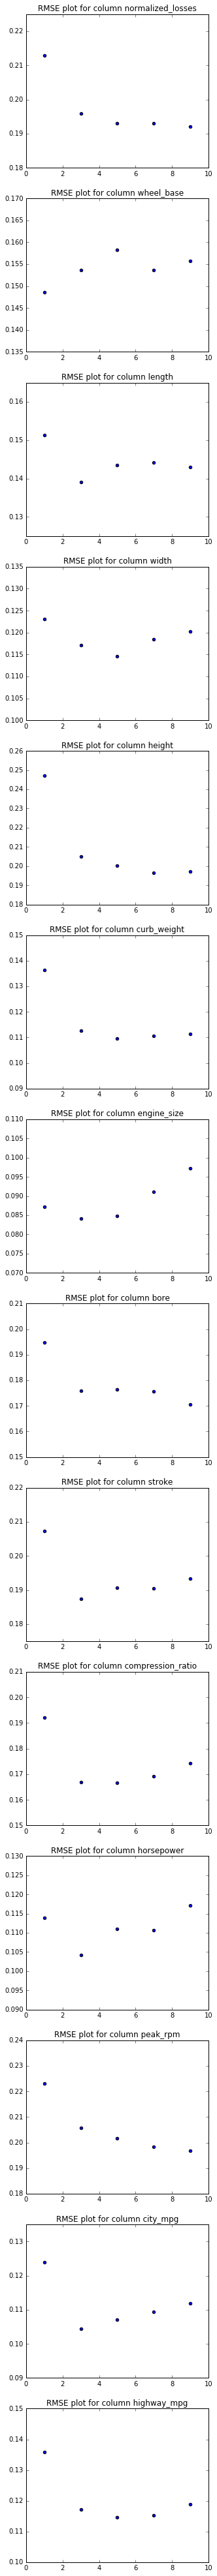

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(len(feature_cols), 1, figsize = (5, 5 * len(feature_cols)))
for i, single_ft_col in enumerate(feature_cols):
    rmse_list = []
    hyper_params = [x for x in range(1, 11, 2)]
    for k in hyper_params:
        rmse = knn_100_times([single_ft_col], target_col, cars, k)
        rmse_list.append(rmse)
    # plot the resulting RMSEs
    ax[i].scatter(hyper_params, rmse_list)
    ax[i].set_title("RMSE plot for column " + single_ft_col)
plt.show()

From above, it can be seen that `(k, column) =  (3, "engine_size")` predicts car prices with the least RMSE.

Additionally, there might be some other trends, such as that a larger `k` gives better results for `wheel_base` column and worse results for `peak_rpm` column.

### 4.2 Multivariate

Now we use ML method on multivariate models, using from two to six best feature variables in the univariate case.

In [13]:
six_best_features = ["engine_size", "city_mpg", "curb_weight", "horsepower", "highway_mpg", "width"]
rmse_dict = {}
ft_num_ranges = [x for x in range(2, 7)]
k = 5
for i in ft_num_ranges:
    rmse = knn_100_times(six_best_features[:i], target_col, cars, k)
    rmse_dict[i] = rmse
print(rmse_dict)

{2: 0.0854754752545668, 3: 0.09452736474782546, 4: 0.08974499598646064, 5: 0.09129412555870614, 6: 0.08779979686508034}


From above, the top three models of features combination are 2-combination, 6-combination, and 4-combination.

We will now vary the hyperparameter value `k` from 1 to 25 and plot the RMSE values to see which `k` is optimal for each of the three top models.

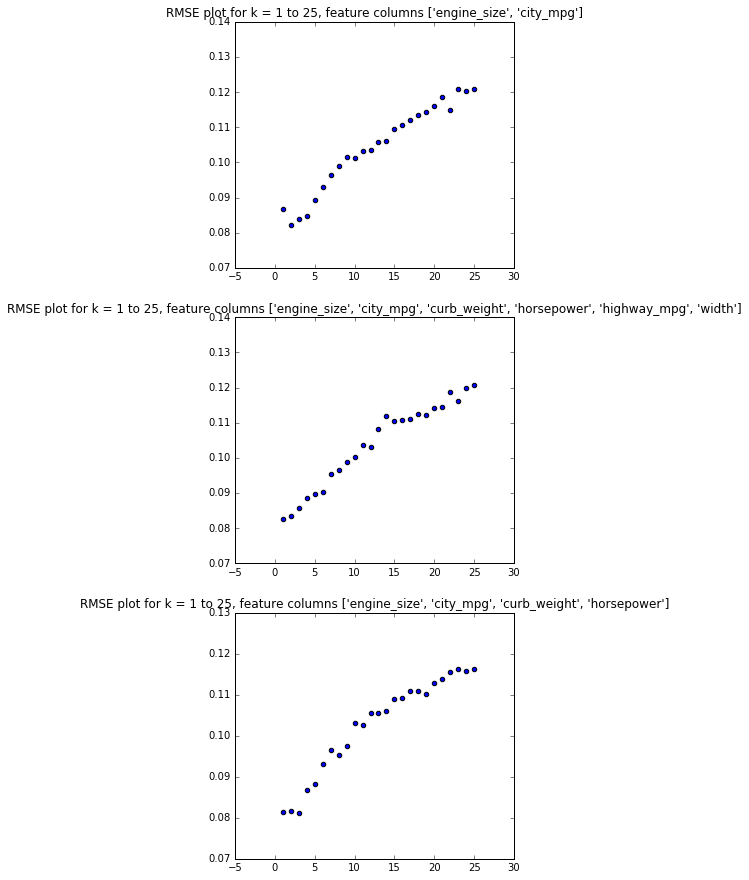

In [14]:
six_best_features = ["engine_size", "city_mpg", "curb_weight", "horsepower", "highway_mpg", "width"]
two_comb_model = six_best_features[:2]
four_comb_model = six_best_features[:4]
six_comb_model =  six_best_features[:6]
comb_models = [two_comb_model, six_comb_model, four_comb_model] # ordered from the least RMSE

hyper_params = [x for x in range(1, 26)]
fig, ax = plt.subplots(3, 1, figsize = (5, 15))
for i, model in enumerate(comb_models):
    rmse_list = []
    for k in hyper_params:
        rmse = knn_100_times(model, target_col, cars, k)
        rmse_list.append(rmse)
    ax[i].scatter(hyper_params, rmse_list)
    ax[i].set_title("RMSE plot for k = 1 to 25, feature columns " + str(model))
plt.show()

For the model with two, six and four best feature variables; the most optimal value of `k` is respectively 2, 1, and 3.

Notice that the RMSE is strictly increasing as `k` increases from 3. This suggests that the car with very similar specifications on `"engine_size", "city_mpg", "curb_weight", "horsepower", "highway_mpg"`, and `"width"` is a good predictor of a car price.

Variables such as the size of engine and total weight (curb weight) may be influenced by the resources to produce a car, while the distance capability (city and highway mpg) may reflect how advanced its employed automotive technology is. The variable width is a bit puzzling, but it may also be a luxury feature of a car, thus contributing to the car price.

## 5. Building Model Using k-Fold Cross Validation

We define a new function `knn_fold()`, a modified method of `knn_train_test()` which uses k-fold cross validation instead of test/train validation. If `knn_train_test()` has parameter `k` for k-nearest neighbor algorithm; `knn_fold()` will have two types of parameter `k`: one for k-nearest neighbor algorithm (`k_neigh`)and one for k-fold cross validation process (`k_fold`$ \ge 2$).

For simplicity, we let `k_neigh = 5`.

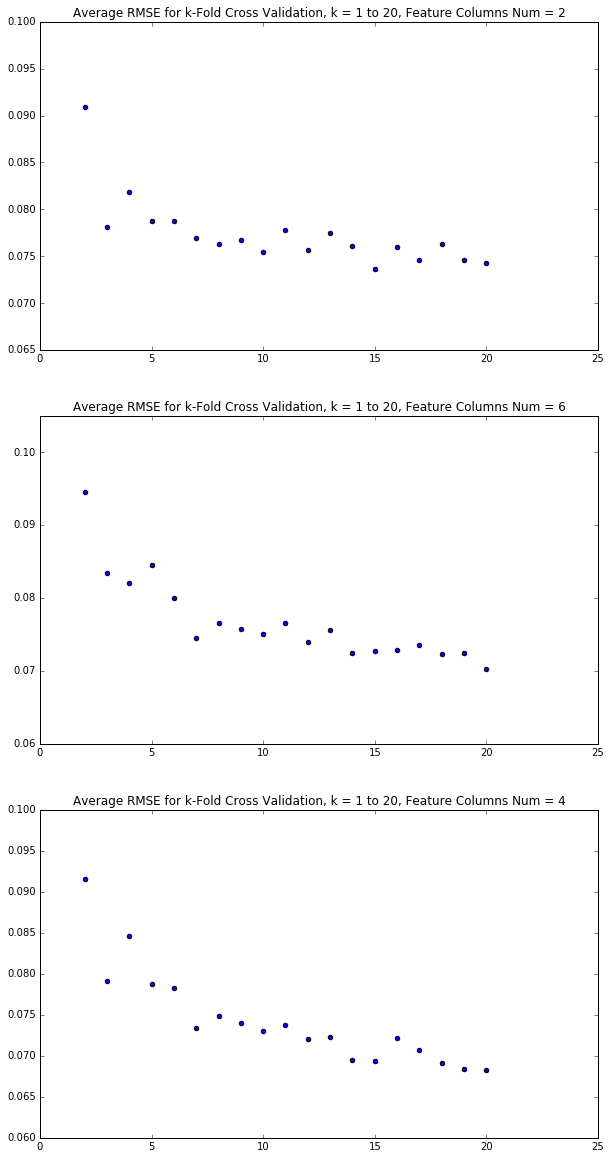

In [24]:
from sklearn.model_selection import cross_val_score, KFold

def knn_fold(feature_cols, target_col, df, k_neigh, k_fold):
    knn = KNeighborsRegressor(n_neighbors = k_neigh)
    kf = KFold(k_fold, shuffle = True, random_state = 1)
    mses = - cross_val_score (knn, df[feature_cols], df[target_col],
                           scoring = "neg_mean_squared_error", cv = kf)
    rmses = np.sqrt(mses)
    return np.mean(rmses), np.std(rmses)

# For simplicity, let k_neigh be the standard value of 5
k_neigh = 5
hyper_params = [x for x in range(2, 21)]
fig, ax = plt.subplots(3, 1, figsize = (10, 20))
for i, model in enumerate(comb_models):
    avg_rmse_list = []
    std_rmse_list = []
    for k_fold in hyper_params:
        avg_rmse, std_rmse = knn_fold(model, target_col, cars, k_neigh, k_fold)
        avg_rmse_list.append(avg_rmse)
        std_rmse_list.append(std_rmse)
    ax[i].scatter(hyper_params, avg_rmse_list)
    ax[i].set_title("Average RMSE for k-Fold Cross Validation, k = 1 to 20, Feature Columns Num = " + str(len(model)))
plt.show()

An interesting pattern here is that as the average RMSE gets more stable (`k_fold` greater than 15); the values of RMSE using six and four features are lower compared to the ones using two features.

This seems to make sense: larger `k_fold` implies lower number of training set of data which are $\frac{1}{k_{fold}}$ of the total rows, and more feature columns balance out the lack of rows to assess. The training-test principle used in `knn_train_test()` is a partial case of `k_fold = 2`, which explains why 2-combination model performs better than 6-combination and 4-combination ones.

## 6. Conclusion

We have analyzed the data set `cars` using the basic machine learning method of k-nearest neighbors. There are 14 numeric columns available as features to predict the price of a car.

We conclude that the six best features for KNN application are `"engine_size", "city_mpg", "curb_weight", "horsepower", "highway_mpg", "width"`. Furthermore, the combination of two, six, and four of these features give the best predictive outcomes.

By varying the hyperparameter for KNN, all the top three models consisting of best feature variables shows that the optimal `k` is a small number from 1 to 3, suggesting the strong correlation of the six features with the car price.

As an extension, we attempted the k-fold cross validation from `k = 2` to `k = 20`. As `k` increases, the 6-combination and 4-combination model starts to perform better than the 2-combination model, which can be reasoned by the reduced number of training data rows as `k` goes up.